<a href="https://colab.research.google.com/github/ClaudioB12/Fake-news-con-LSTM/blob/main/Detecci%C3%B3n_de_fake_news_con_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detección de Fake News usando LSTM Y Deep learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [2]:
!pip install tensorflow==2.15.0

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

print("Todos los módulos se han importado correctamente.")


Todos los módulos se han importado correctamente.


# Exploración de fake news

In [4]:
fake = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')

In [5]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [7]:
fake['subject'].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

<Axes: xlabel='subject', ylabel='count'>

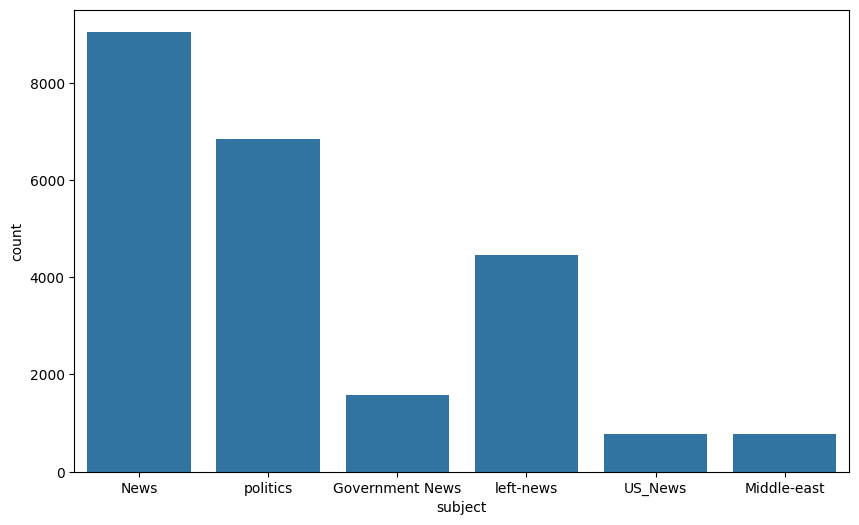

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x = 'subject',data=fake)

**Wordcloud**


In [9]:
text = ' '.join(fake['text'].tolist())

In [10]:
' '.join(['this', 'is', 'a', 'data'])

'this is a data'

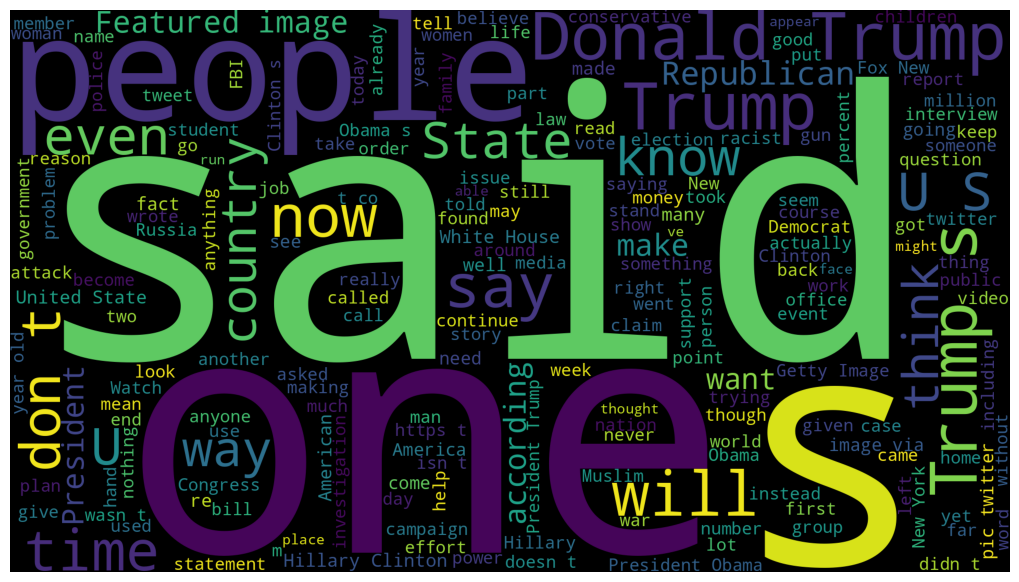

In [11]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Explorando con noticias reales

In [12]:
real = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')

In [13]:
text = ' '.join(real['text'].tolist())

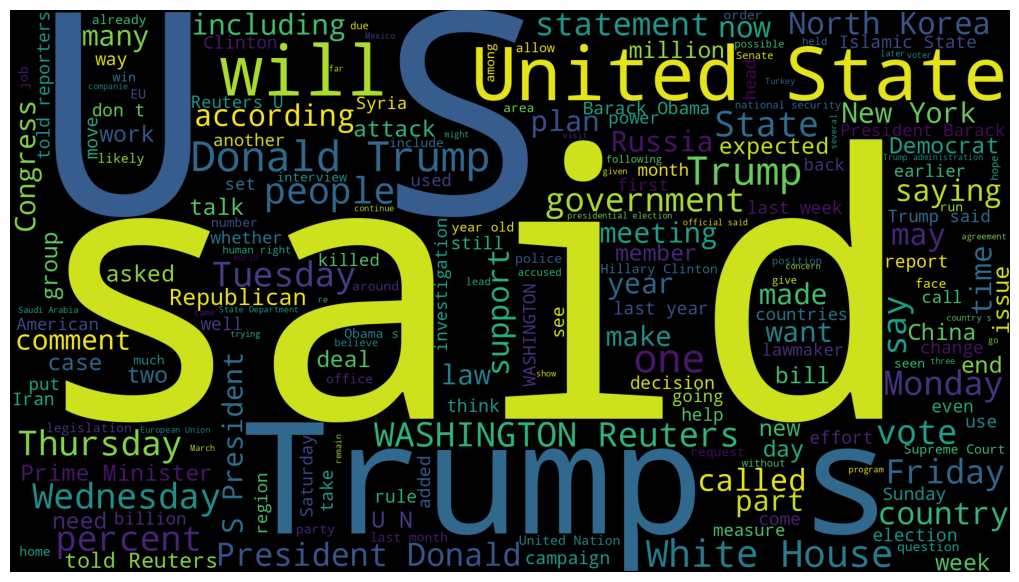

In [14]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [15]:
real.sample(5)

,title,text,subject,date
3483,Fed official says U.S. immigration crackdown c...,NEW YORK (Reuters) - The Trump administration’...,politicsNews,"May 31, 2017"
7466,Greece's Golden Dawn says Trump win a victory ...,ATHENS (Reuters) - Greece’s far-right Golden D...,politicsNews,"November 9, 2016"
17753,Arab rivalries exposed as Egypt targets Qatar ...,PARIS (Reuters) - Arab states may want their t...,worldnews,"October 11, 2017"
18793,"Feeling left out, under threat, east Germans r...","DIPPOLDISWALDE, Germany (Reuters) - Like a thi...",worldnews,"September 28, 2017"
9018,House Republicans move to shut down Democratic...,WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"June 23, 2016"


In [16]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
    try:
      record = row.split('-', maxsplit=1)
      record[1]

      assert(len(record[0])<120)
    except:
      unknown_publishers.append(index)

In [17]:
len(unknown_publishers)

222

In [18]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [19]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [ ]:
# real = real.drop(8970, axis=0)

In [20]:
publisher = []
tmp_text = []

for index, row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')

  else:
    record = row.split('-', maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())


In [21]:
real['publisher']=publisher
real['text'] = tmp_text

In [22]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [23]:
real.shape

(21417, 5)

In [24]:
empty_fake_index = [index for index,text in enumerate (fake.text.tolist()) if str(text).strip()==""]

In [25]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [26]:
real['text'] = real['title'] + " " + real['text']
fake['text'] = fake['title'] + " " + fake['text']

In [27]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

# Preprocesamiento de texto

In [28]:
real['class'] = 1
fake['class'] = 0

In [29]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [30]:
real = real[['text', 'class']]

In [31]:
fake = fake[['text', 'class']]

In [32]:
data = pd.concat([real, fake], ignore_index=True)

In [33]:
data.sample(5)

,text,class
10854,louisiana governor says state's finances in di...,1
6203,china's future actions could warrant forex man...,1
9430,house rejects bill requiring carriers to share...,1
4584,kansas governor vetoes medicaid expansion bill...,1
7168,"factbox: trump to meet with huckabee, romney, ...",1


In [34]:
# https://github.com/laxmimerit/preprocess_kgptalkie

In [35]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4
!pip install textblob
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 56.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-ymgrx1av
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-ymgrx1av
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 96bf02872d9756f29d6cddb8aafaedcd2a39bbb4
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7603 sha256=1b76579b9bad7c869403cd9abdfa8062e4644c8e9d70c0d731e3702a76ef738d
  Stored in di

In [36]:
import preprocess_kgptalkie as ps

In [37]:
data['text'] = data['text'].apply(lambda x: ps.remove_special_chars(x))

In [38]:
ps.remove_special_chars('this ,. @ # is gre@t')

'this is gret'

In [39]:
data.head()

,text,class
0,as us budget fight looms republicans flip thei...,1
1,us military to accept transgender recruits on ...,1
2,senior us republican senator let mr mueller do...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge much more...,1


In [40]:
import gensim

In [41]:
y = data['class'].values

In [42]:
X = [d.split() for d in data['text'].tolist()]

In [43]:
type(X[0])

list

In [44]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [45]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=10, min_count=1)

In [46]:
len(w2v_model.wv.key_to_index)

231911

In [47]:
w2v_model.wv.key_to_index

{'the': 0,
 'to': 1,
 'of': 2,
 'a': 3,
 'and': 4,
 'in': 5,
 'that': 6,
 'on': 7,
 'for': 8,
 's': 9,
 'is': 10,
 'he': 11,
 'said': 12,
 'trump': 13,
 'it': 14,
 'with': 15,
 'was': 16,
 'as': 17,
 'his': 18,
 'by': 19,
 'has': 20,
 'be': 21,
 'have': 22,
 'not': 23,
 'from': 24,
 'this': 25,
 'at': 26,
 'are': 27,
 'who': 28,
 'us': 29,
 'an': 30,
 'they': 31,
 'i': 32,
 'but': 33,
 'we': 34,
 'would': 35,
 'president': 36,
 'about': 37,
 'will': 38,
 'their': 39,
 'had': 40,
 'you': 41,
 't': 42,
 'been': 43,
 'were': 44,
 'people': 45,
 'more': 46,
 'or': 47,
 'after': 48,
 'which': 49,
 'she': 50,
 'her': 51,
 'one': 52,
 'if': 53,
 'its': 54,
 'out': 55,
 'all': 56,
 'what': 57,
 'state': 58,
 'when': 59,
 'new': 60,
 'also': 61,
 'up': 62,
 'there': 63,
 'over': 64,
 'no': 65,
 'house': 66,
 'donald': 67,
 'our': 68,
 'states': 69,
 'clinton': 70,
 'obama': 71,
 'government': 72,
 'can': 73,
 'just': 74,
 'him': 75,
 'so': 76,
 'than': 77,
 'republican': 78,
 'other': 79,
 'som

In [48]:
w2v_model.wv['peru']

array([-0.8384488 , -0.39396065, -1.1240743 ,  0.26386276, -0.5876363 ,
       -1.1933366 ,  1.8966335 ,  1.005817  , -2.525316  ,  0.56051534,
       -0.35390967,  0.3215364 ,  0.07887557,  0.06503852,  0.07037704,
        0.40039974,  1.3779327 ,  0.49446303, -0.60174453, -1.0384742 ,
       -0.870776  ,  0.15696102, -0.86203426, -0.01686097,  0.44461146,
        1.2587445 ,  1.4811213 ,  0.84546924, -0.42585784,  1.1261197 ,
        0.21228066, -0.90157676,  1.0140967 , -0.08061395,  2.119468  ,
        1.8758663 , -0.3517947 , -0.9573448 ,  1.0057597 , -0.10065366,
       -1.1337014 , -0.69179744, -0.5024023 ,  0.43198624,  0.68665445,
        1.1355989 ,  0.11299043,  0.22357586, -1.2507659 , -1.4248866 ,
        0.09821872, -1.3529944 , -0.42584845,  0.4193124 , -0.07918433,
        0.07554149,  1.2073402 , -0.10470077,  0.45550242, -1.1534945 ,
        0.01174506, -0.42565054, -0.2690769 ,  0.3813038 ,  0.72803307,
        0.882311  ,  0.8300216 , -0.7967748 ,  0.05076888, -0.85

In [49]:
w2v_model.wv.most_similar('peru')

[('argentina', 0.7726393342018127),
 ('chile', 0.7199536561965942),
 ('ecuador', 0.6942911744117737),
 ('brazil', 0.6889613270759583),
 ('colombia', 0.6884356141090393),
 ('bolivia', 0.6554508209228516),
 ('perus', 0.6308885216712952),
 ('felipe', 0.629728376865387),
 ('chilean', 0.6204864382743835),
 ('macri', 0.6148651838302612)]

In [50]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [51]:
X = tokenizer.texts_to_sequences(X)

In [52]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'said': 13,
 'trump': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'not': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'us': 30,
 'an': 31,
 'they': 32,
 'i': 33,
 'but': 34,
 'we': 35,
 'would': 36,
 'president': 37,
 'about': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'were': 45,
 'people': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'its': 55,
 'out': 56,
 'all': 57,
 'what': 58,
 'state': 59,
 'when': 60,
 'new': 61,
 'also': 62,
 'up': 63,
 'there': 64,
 'over': 65,
 'no': 66,
 'house': 67,
 'donald': 68,
 'our': 69,
 'states': 70,
 'clinton': 71,
 'obama': 72,
 'government': 73,
 'can': 74,
 'just': 75,
 'him': 76,
 'so': 77,
 'than': 78,
 'republican': 79,
 'other': 80,
 'so

In [53]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'said': 13,
 'trump': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'not': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'us': 30,
 'an': 31,
 'they': 32,
 'i': 33,
 'but': 34,
 'we': 35,
 'would': 36,
 'president': 37,
 'about': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'were': 45,
 'people': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'its': 55,
 'out': 56,
 'all': 57,
 'what': 58,
 'state': 59,
 'when': 60,
 'new': 61,
 'also': 62,
 'up': 63,
 'there': 64,
 'over': 65,
 'no': 66,
 'house': 67,
 'donald': 68,
 'our': 69,
 'states': 70,
 'clinton': 71,
 'obama': 72,
 'government': 73,
 'can': 74,
 'just': 75,
 'him': 76,
 'so': 77,
 'than': 78,
 'republican': 79,
 'other': 80,
 'so

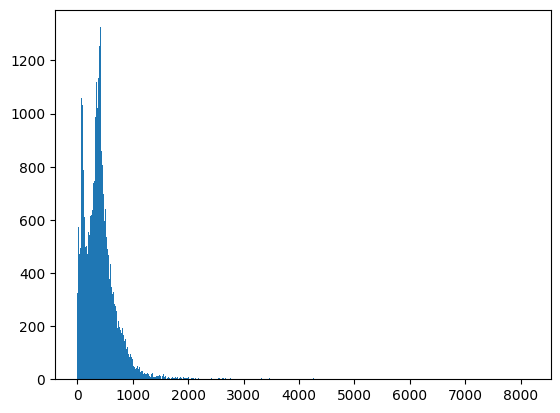

In [54]:
plt.hist([len(x) for x in X], bins = 700)
plt.show()

In [55]:
nos = np.array([len(x) for x in X])
nos[nos>1000]
len(nos[nos>1000])

1584

In [56]:
maxlen = 1000
X = pad_sequences(X, maxlen=maxlen)

In [57]:
len(X[101])

1000

In [58]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [59]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))

  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [60]:
embedding_vectors = get_weight_matrix(w2v_model)

In [61]:
embedding_vectors.shape

(231912, 100)

In [62]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights = [embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         23191200  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 23308577 (88.92 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 23191200 (88.47 MB)
_________________________________________________________________


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [66]:
model.fit(X_train, y_train, validation_split=0.3, epochs=20)

Epoch 1/20
737/737 [==============================] - 29s 39ms/step - loss: 0.0821 - acc: 0.9719 - val_loss: 0.0651 - val_acc: 0.9810
Epoch 2/20
737/737 [==============================] - 28s 38ms/step - loss: 0.0377 - acc: 0.9881 - val_loss: 0.0412 - val_acc: 0.9860
Epoch 3/20
737/737 [==============================] - 31s 42ms/step - loss: 0.0235 - acc: 0.9926 - val_loss: 0.0229 - val_acc: 0.9932
Epoch 4/20
737/737 [==============================] - 29s 39ms/step - loss: 0.0124 - acc: 0.9964 - val_loss: 0.0204 - val_acc: 0.9938
Epoch 5/20
737/737 [==============================] - 29s 40ms/step - loss: 0.0102 - acc: 0.9965 - val_loss: 0.0161 - val_acc: 0.9945
Epoch 6/20
737/737 [==============================] - 28s 38ms/step - loss: 0.0045 - acc: 0.9985 - val_loss: 0.0180 - val_acc: 0.9956
Epoch 7/20
737/737 [==============================] - 28s 38ms/step - loss: 0.0067 - acc: 0.9980 - val_loss: 0.0141 - val_acc: 0.9957
Epoch 8/20
737/737 [==============================] - 28s 38ms

In [67]:
y_pred = (model.predict(X_test) >=0.5).astype(int)

351/351 [==============================] - 6s 15ms/step


In [68]:
accuracy_score(y_test, y_pred)

0.9947438752783965

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5882
           1       1.00      0.99      0.99      5343

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [70]:
x = ['Noticia falsa']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [71]:
(model.predict(x) >=0.5).astype(int)

1/1 [==============================] - 0s 60ms/step


array([[0]])

In [72]:
X_test

array([[     0,      0,      0, ...,   6571,   1923,    478],
       [     0,      0,      0, ...,   7340,   2496,  35755],
       [     0,      0,      0, ...,     15,    106,     22],
       ...,
       [     0,      0,      0, ...,    197,    175,   3827],
       [     0,      0,      0, ...,     85,   3988,   1061],
       [     0,      0,      0, ...,    175, 229737,   2242]], dtype=int32)

In [73]:
model.predict(x)

1/1 [==============================] - 0s 77ms/step


array([[0.00105065]], dtype=float32)

In [74]:
x = ['Los expertos en desinformación dicen que China podría estar dando una mano en la difusión de este mensaje e, incluso, ser la fuente del mismo. Sus pruebas también apuntan a taiwaneses cercanos a Pekín.']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)
(model.predict(x) >=0.5).astype(int)

1/1 [==============================] - 0s 27ms/step


array([[1]])

In [75]:
x = ['Desde el 7 de octubre de 2023, la escalada de la crisis en Israel y el territorio palestino ocupado ha provocado un gran número de muertos y heridos entre los civiles.']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)
(model.predict(x) >=0.5).astype(int)

1/1 [==============================] - 0s 27ms/step


array([[0]])